<h1>Team Haus Masterz</h1>
<b>
has undertaken an extensive effort to synthesize data from the <a href="https://github.com/dbkinghorn/blog-jupyter-notebooks">House Sales in King County, USA</a> dataset. Unpacking this data will unravel the multitude of relationships between housing prices in King County and a number of other attenuating factors. 

The Team Haus Masterz hypotheses are thus:


-There is a correlation between location of housing properties and the subsequent housing price.

-There are positive correlations between the size of the haus and the housing price.

-There are correlations between year built and price.

Following is our methodology for organizing, cleaning, and testing our housing data. During our process we worked to find the data that best represents our relationship with the Housing Price . The results may surprise you.

In [298]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
%matplotlib inline
kc_houses = pd.read_csv('kc_house_data.csv')

Here we are just importing all of our libraries as well as importing our dataset from a comma separated values file.

In [299]:
def Lin_Reg_Model(LinReg_Var,X_train, Y_train, X_test, Y_test):
    """
    Function for Checking for Linear Regression
    Plots a scatter plot of Predicted and Test Data
    Prints the explained Variance Score as well as root mean squared error
    """
    mod = LinReg_Var.fit(X_train, Y_train)
    y_pred = mod.predict(X_test)
    plt.figure(figsize = (15,12))
    plt.scatter(y_pred,Y_test)
    plt.plot(Y_test,Y_test,color = 'orange')
    plt.xlim(y_pred.min()-(np.sqrt(mean_squared_error(y_pred,Y_test))),y_pred.max()+(np.sqrt(mean_squared_error(y_pred,Y_test))))
    plt.show()
    print("explained variance score: ", explained_variance_score(Y_test,y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_pred,Y_test)))
    print(mod.coef_)

def Lin_Reg_Model_Log(LinReg_Var,X_train, Y_train, X_test, Y_test):
    """
    Calculates linear regression model based on X_train and ln(Y_train)
    Plots a scatter plot of Predicted and Test Data
    Prints the explained Variance Score
    """
    mod = LinReg_Var.fit(X_train, np.log(Y_train))
    y_pred = mod.predict(X_test)
    plt.figure(figsize = (15,12))
    plt.scatter(np.e**y_pred, Y_test)
    plt.plot(Y_test,Y_test,color = 'orange')
    plt.xlim(0,np.e**y_pred.max()+(np.sqrt(mean_squared_error(y_pred,Y_test))/10))
    plt.show()
    print("explained variance score: ", explained_variance_score(Y_test,np.e**y_pred))
    print("RMSE: ", np.sqrt(mean_squared_error(y_pred,Y_test)))

In [6]:
kc_houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

See column_names.md for an explanation of content of each column

In [3]:
kc_houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We can see that some of the data has NaN values. We need to decide what to do with those.

In [4]:
kc_houses.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The NaN values are for the Waterfront, the View and the year Renovated. We will need to potentially adjust these later.

First thing we want to do is to create a giant pairplot set to get a quick glance about what some of the relationships are with this data. However, plotting a scatter matrix of every feature in the dataframe takes up a large amount of memory and a lot of time.  Rather than plot all variables, we will plot only the variables we expect to correlate with price.

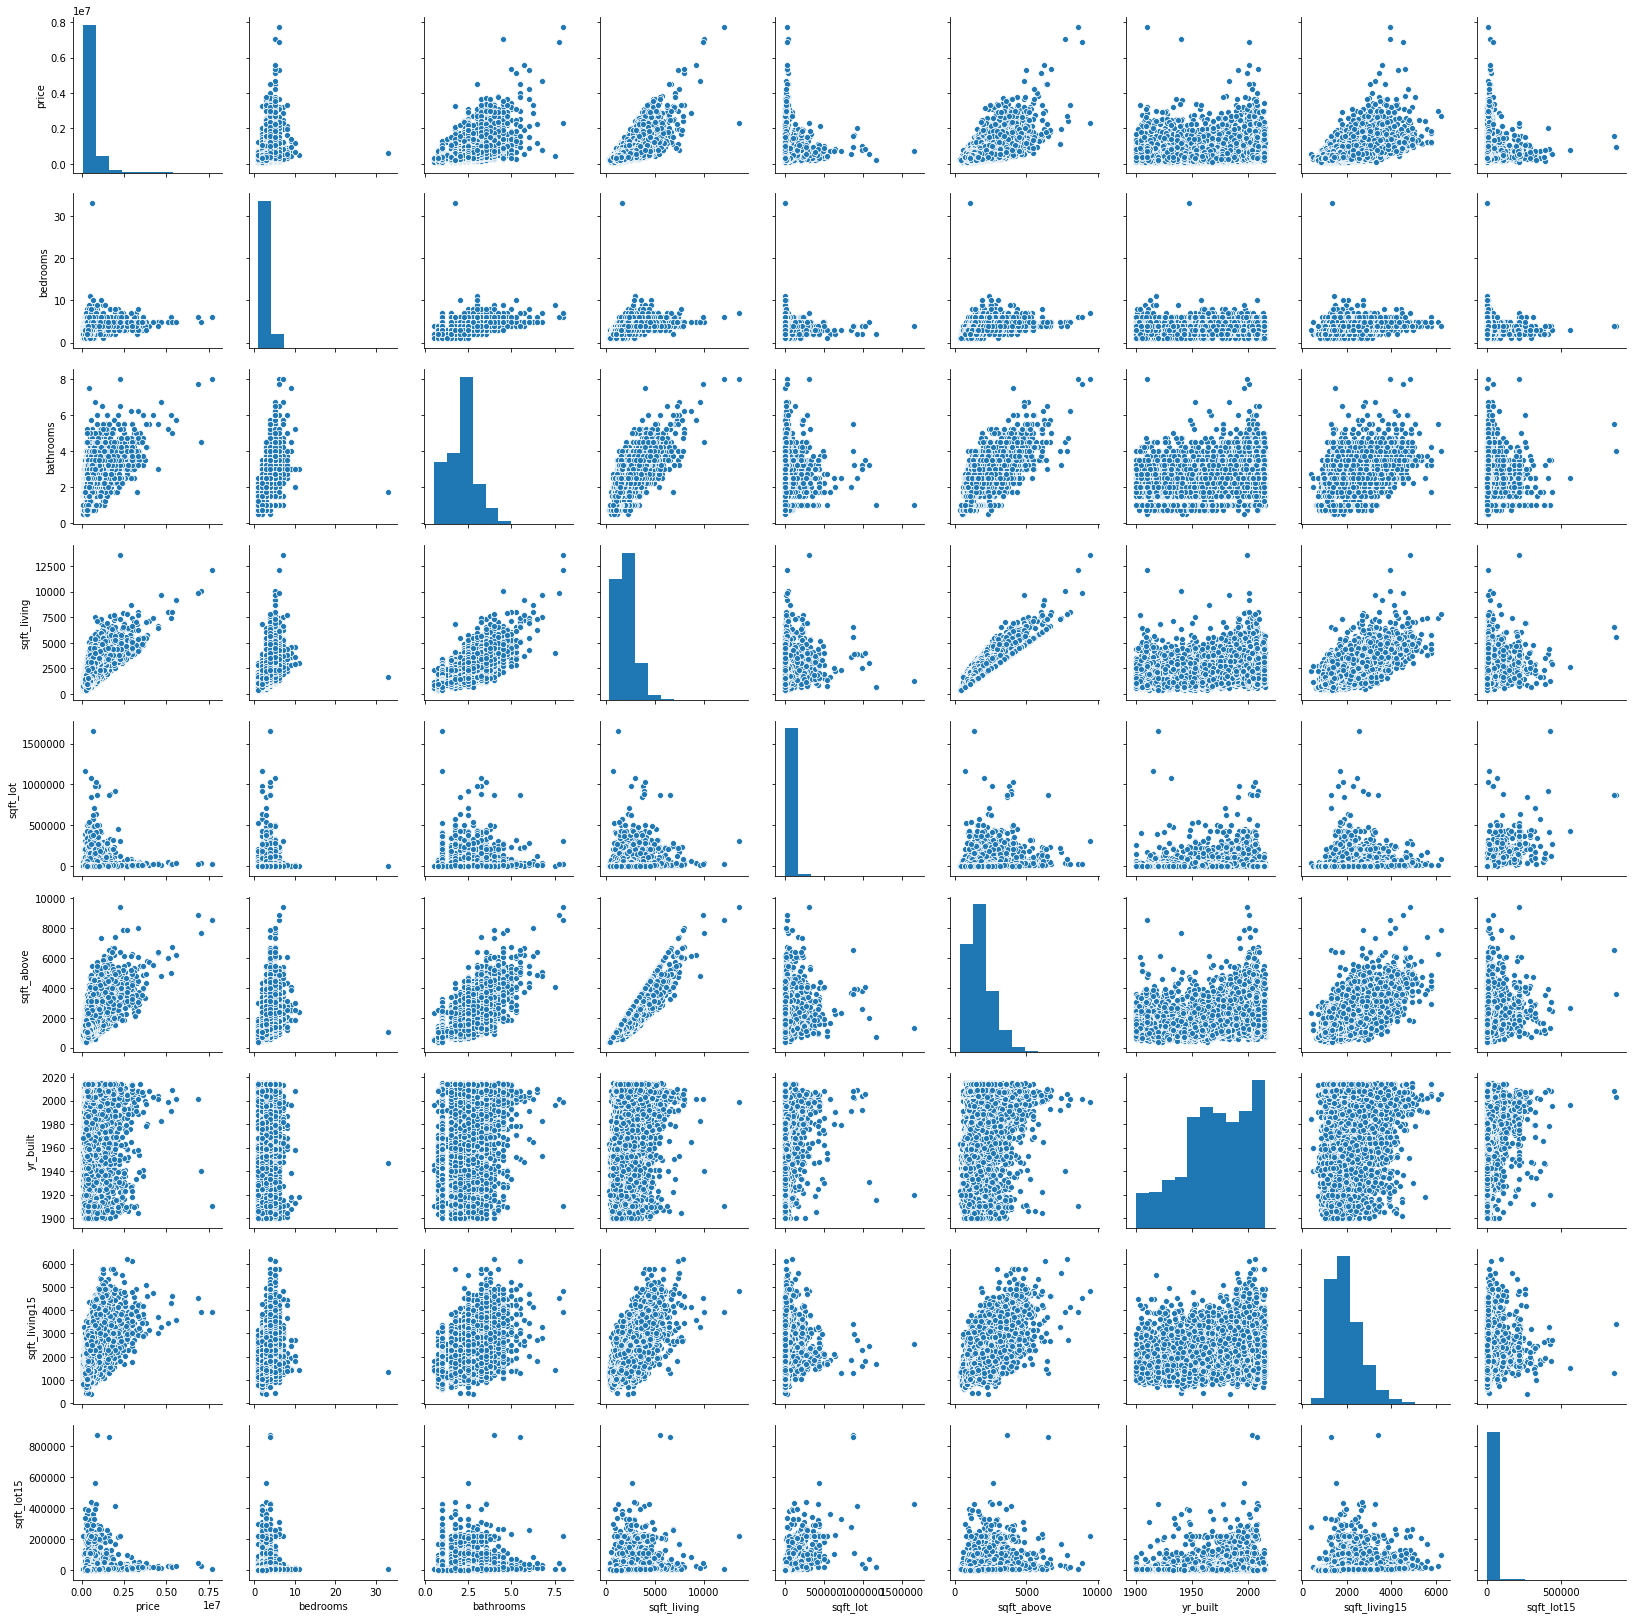

In [7]:
smaller = kc_houses[['price','bedrooms','bathrooms','sqft_living','sqft_lot','sqft_basement','sqft_above','yr_built','sqft_living15','sqft_lot15']]
sns.pairplot(smaller)

Some features appear to be correlated with one another - in particular, features such as bedrooms, bathrooms, and sqft_above are correlated with sqft_living. We have to be very careful before interpreting anything here with a positive correlation. So we will need to do some more data cleaning and exploration.

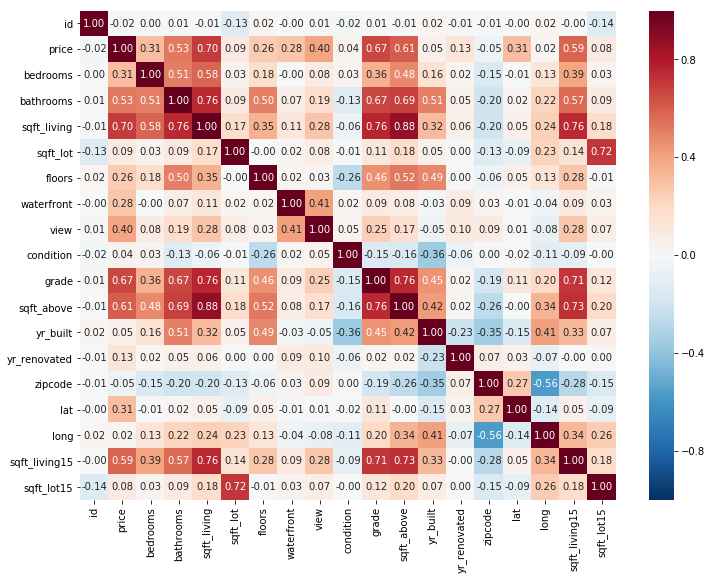

In [6]:
correlation = kc_houses.corr()
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(correlation, annot=True, fmt = '.2f', linewidths=0, vmin=-1, cmap="RdBu_r")

As we can see the more red the squares get, the more positive a correlation between the two features; the more a blue a square, the more negatively correlated the two features are. The deep red squares on the diagonal show each feature's correlation of 1.0 with itself. 

There are many other types of graphs we can create like this but they are probably too much of a birds eye view. We need to explore the data on a more granular level. 

We should probably start by cleaning up the data.

In [7]:
kc_houses['waterfront'].unique()

array([nan,  0.,  1.])

So we have some NaN values on our waterfront section but either you have a waterfront or you don't. As we see below, the vast majority of the properties do not have a waterfront.

In [8]:
kc_houses['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [10]:
kc_houses['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

Most houses haven't been viewed; most houses that have been viewed have been viewed twice.

In [11]:
kc_houses['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

Given that the vast majority of lots have a value of 0 for 'yr_renovated' and >10% of the values for 'yr_renovated' are missing, we will replace 'yr_renovated' with a dummy variable 'was_renovated'; all lots that have a year in which they were renovated will be represented with a 1, and all other lots will be represented with 0.

In [300]:
kc_houses['was_renovated']= kc_houses['yr_renovated'].fillna(0)
temp = kc_houses['was_renovated'].astype(bool).astype(int)
kc_houses['was_renovated'] = temp
kc_houses.drop(columns = ['yr_renovated'],inplace =True)

Roughly 10% of records have a null value for 'waterfront'. Given that a large number of records have a null value for waterfront but we think this information may have a bearing on sale price, it would not be practical to simply drop the rows for which waterfront has a null value. Instead, null values in the waterfront column will be replaced with 0.

In [301]:
kc_houses['waterfront'].fillna(0,inplace=True)

Given that only 63 rows are missing values for 'view', we will simply drop the rows that have a null value for 'view'

In [302]:
no_view = kc_houses['view'].isna()
kc_houses.drop(kc_houses[no_view].index,inplace=True)

In [15]:
kc_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
was_renovated    21534 non-null int64
dtypes: float64(7), int64(12), object(2)
memory usage: 3.6+ MB


The purpose of performing the above function is to make sure that all of our datasets are in the right format. Here we see that 'sqft_basement' is not an integer or a float but is for some reason a string? Converting this to float will likely prevent errors with our linear regression modeling in the future.

If the square footage above ground equals the total square footage of the house, we conclude the size of the basement is 0 sq. ft. Otherwise, we conclude that the size of the basement is the difference between total square footage and sqft_above

In [303]:
kc_houses.loc[kc_houses['sqft_above']==kc_houses['sqft_living'],'sqft_basement']=0

In [304]:
weird_basement = kc_houses[kc_houses['sqft_basement']=='?']
# len(weird_basement['sqft_living'].as_matrix())
weird_basement.loc[:,'sqft_basement'] = weird_basement.loc[:,'sqft_living']-weird_basement.loc[:,'sqft_above']

In [305]:
kc_houses.loc[weird_basement.index,'sqft_basement']=weird_basement['sqft_basement']

In [306]:
kc_houses['has_basement'] = kc_houses['sqft_basement'].astype(bool).astype(int)

We also want to take a look at the number of bedrooms to see if they are a contributing factor to housing price.

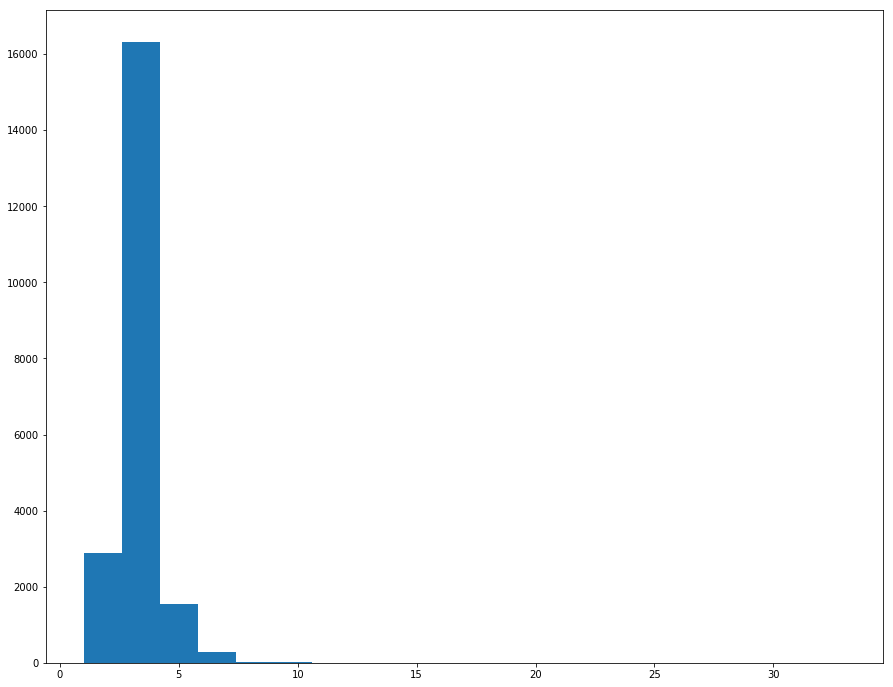

In [12]:
plt.figure(figsize = (15,12))
plt.hist(kc_houses['bedrooms'],bins = 20)
plt.show()

It's hard to tell from this chart, but there is one house that has 33 bedrooms. This really skews our distribution and is most likely an error in data entry (e.g. that house may actually have 3 bedrooms, but someone accidentally pressed the '3'key twice).

In order to normalize our distribution, we should try to cut out houses from our histogram that have more than 15 bedrooms.

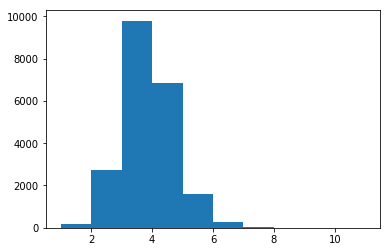

In [307]:
too_many_bedrooms = kc_houses[kc_houses['bedrooms']>15]
kc_houses.drop(too_many_bedrooms.index,inplace =True)
#if you dont place .index this will return an empty dataframe, inplace = True tells this to
#change the original dataframe.
# kc_houses.drop(kc_houses[kc_houses['price']>5000000].index,inplace=True)
plt.hist(kc_houses['bedrooms'])
plt.show()

Let's also keep in mind that King County is the home to many tech groups as well as a number of very rich individuals; their houses likely skew the distribution of house price toward the right.

Text(0.5, 1.0, 'House Sale Price Distribution')

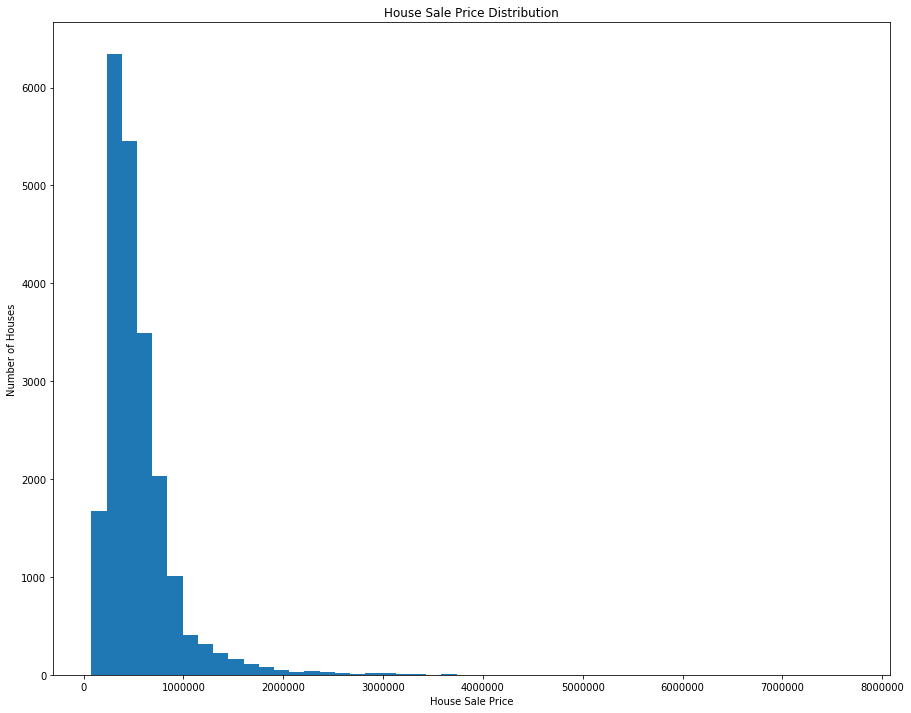

In [264]:
plt.figure(figsize = (15,12))
plt.hist(kc_houses['price'],bins = 50)
plt.xlabel('House Sale Price')
plt.ylabel('Number of Houses')
plt.title('House Sale Price Distribution')
# plt.savefig('price_dist')

Let's see if log transforming sale price produces a more normal distribution

In [270]:
kc_houses['sqft_living'].describe()

count    21533.000000
mean      2079.849208
std        917.462472
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [269]:
np.percentile(kc_houses['sqft_living'],90)

3250.0

In [271]:
kc_houses['price'].describe()

count    2.153300e+04
mean     5.400530e+05
std      3.660674e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [280]:
np.percentile(kc_houses['price'],97.5)

1490000.0

In [308]:
kc_houses['price_per_sq_ft_lot'] =kc_houses['price']/kc_houses['sqft_lot']

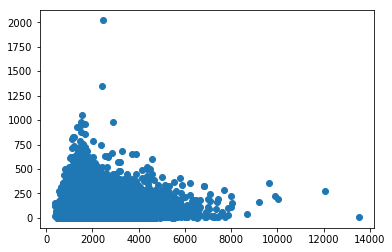

In [309]:
plt.scatter(kc_houses['sqft_living'], kc_houses['price_per_sq_ft_lot'])

(array([7.208e+03, 6.512e+03, 3.277e+03, 1.666e+03, 9.030e+02, 5.570e+02,
        3.400e+02, 2.660e+02, 2.330e+02, 1.730e+02, 1.410e+02, 8.800e+01,
        5.700e+01, 2.900e+01, 2.400e+01, 1.900e+01, 1.300e+01, 6.000e+00,
        6.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.63118972e-01, 4.05539453e+01, 8.09447716e+01, 1.21335598e+02,
        1.61726424e+02, 2.02117250e+02, 2.42508077e+02, 2.82898903e+02,
        3.23289729e+02, 3.63680556e+02, 4.04071382e+02, 4.44462208e+02,
        4.84853034e+02, 5.25243861e+02, 5.65634687e+02, 6.06025513e+02,
        6.46416340e+02, 6.86807166e+02, 7.27197992e+02, 7.67588818e+02,
        8.079796

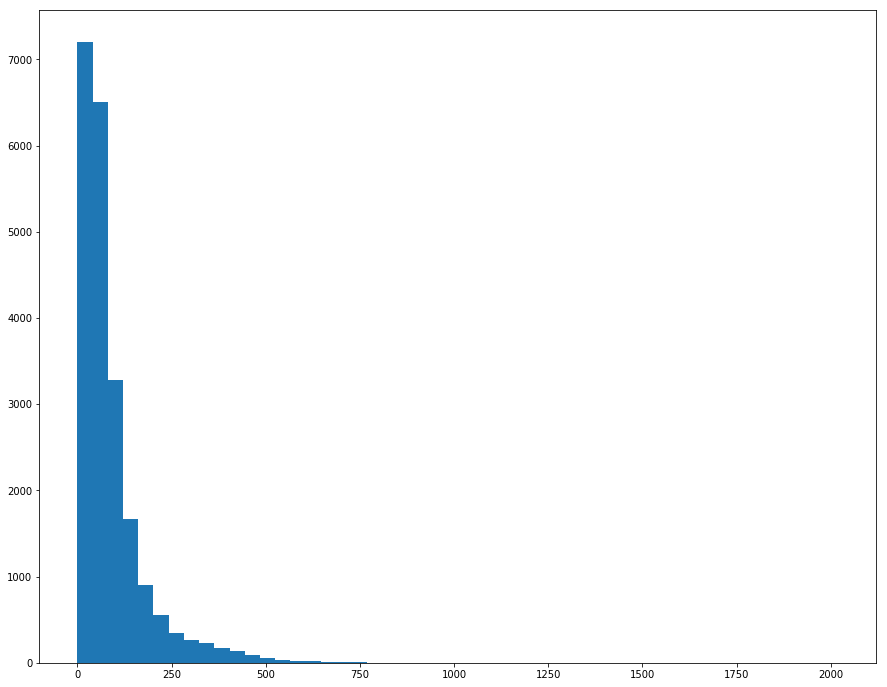

In [295]:
plt.figure(figsize = (15,12))
plt.hist(kc_houses['price_per_sq_ft'], bins =50)

In [296]:
kc_houses['price_per_sq_ft'].describe()

count    21533.000000
mean        89.014948
std         94.141882
min          0.163119
25%         33.333333
50%         59.262128
75%        107.615645
max       2019.704433
Name: price_per_sq_ft, dtype: float64

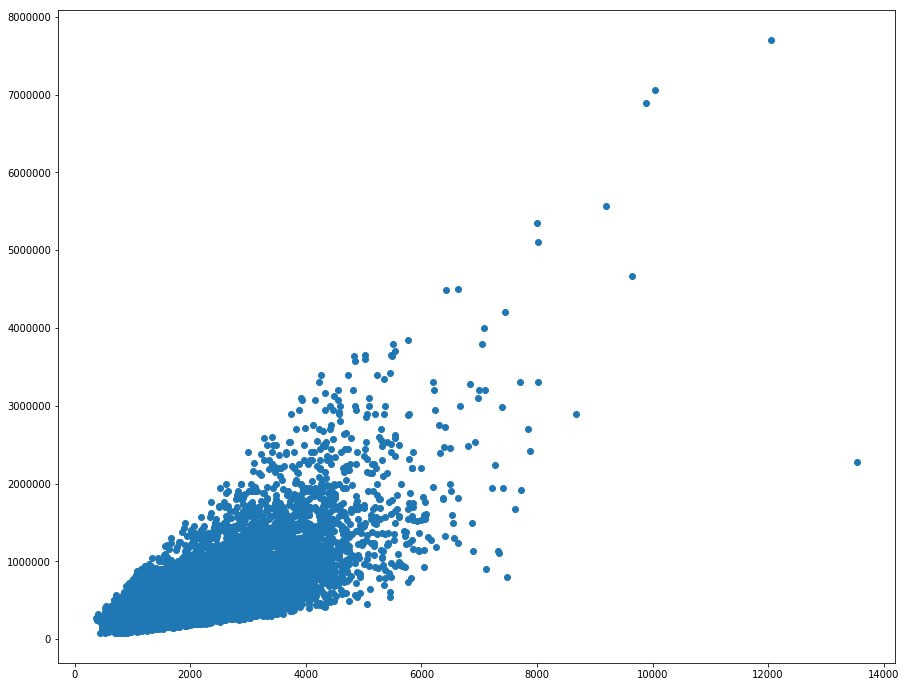

In [275]:
plt.figure(figsize = (15,12))
plt.scatter(kc_houses['sqft_living'],kc_houses['price'])

In [310]:
too_big = kc_houses[kc_houses['price']>1490000]

In [311]:
too_big.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,was_renovated,has_basement,price_per_sq_ft_lot
count,5.320000e+02,5.320000e+02,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,4.103460e+09,2.101259e+06,4.210526,3.507049,4410.109023,29804.703008,1.855263,0.135338,1.597744,3.500000,...,3597.334586,1975.281955,98059.701128,47.617096,-122.225113,3306.257519,21215.265038,0.120301,0.640977,172.940735
std,2.767117e+09,7.241430e+05,0.916907,0.935451,1341.553973,79279.848156,0.485874,0.342407,1.659259,0.730039,...,1240.358942,32.563590,54.764476,0.053712,0.096831,827.728534,48233.077737,0.325619,0.480165,114.704987
min,4.610020e+07,1.500000e+06,2.000000,1.500000,1910.000000,1880.000000,1.000000,0.000000,0.000000,1.000000,...,1340.000000,1900.000000,98004.000000,47.416900,-122.416000,1280.000000,2199.000000,0.000000,0.000000,1.836547
25%,1.801260e+09,1.650000e+06,4.000000,2.750000,3520.000000,8504.750000,2.000000,0.000000,0.000000,3.000000,...,2630.000000,1951.000000,98006.000000,47.581075,-122.283000,2777.500000,8520.000000,0.000000,0.000000,96.846804
50%,3.625049e+09,1.870000e+06,4.000000,3.500000,4230.000000,13734.000000,2.000000,0.000000,1.000000,3.000000,...,3440.000000,1985.500000,98040.000000,47.624950,-122.224000,3240.000000,12776.000000,0.000000,1.000000,151.142042
75%,6.072800e+09,2.320000e+06,5.000000,4.000000,5020.000000,20740.250000,2.000000,0.000000,3.000000,4.000000,...,4286.250000,2004.000000,98112.000000,47.640900,-122.200750,3822.500000,19229.750000,0.000000,1.000000,226.531802
max,9.831200e+09,7.700000e+06,8.000000,8.000000,13540.000000,920423.000000,3.500000,1.000000,4.000000,5.000000,...,9410.000000,2015.000000,98199.000000,47.766600,-121.756000,6210.000000,858132.000000,1.000000,1.000000,984.042553


In [312]:
ninety_seven = kc_houses[kc_houses['price']<=1490000]

In [313]:
ninety_seven.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,was_renovated,has_basement,price_per_sq_ft_lot
count,2.100100e+04,2.100100e+04,21001.000000,21001.000000,21001.000000,2.100100e+04,21001.000000,21001.000000,21001.000000,21001.000000,...,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000
mean,4.594586e+09,5.005043e+05,3.350412,2.080484,2020.818771,1.471829e+04,1.485001,0.003476,0.199324,3.407362,...,1742.773011,1970.895005,98078.400171,47.558732,-122.213660,1952.893862,12537.047045,0.032332,0.386267,86.888929
std,2.878560e+09,2.466374e+05,0.893690,0.730293,822.499507,3.989018e+04,0.537976,0.058857,0.695141,0.648295,...,760.687637,29.283766,53.395885,0.139711,0.141662,647.074773,26476.907297,0.176884,0.486905,92.582768
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000,0.163119
25%,2.125059e+09,3.199500e+05,3.000000,1.500000,1410.000000,5.001000e+03,1.000000,0.000000,0.000000,3.000000,...,1180.000000,1951.000000,98033.000000,47.466000,-122.330000,1480.000000,5074.000000,0.000000,0.000000,32.920354
50%,3.905041e+09,4.450000e+05,3.000000,2.250000,1890.000000,7.552000e+03,1.000000,0.000000,0.000000,3.000000,...,1540.000000,1975.000000,98065.000000,47.569500,-122.231000,1820.000000,7562.000000,0.000000,0.000000,58.059749
75%,7.334600e+09,6.250000e+05,4.000000,2.500000,2490.000000,1.045400e+04,2.000000,0.000000,0.000000,4.000000,...,2150.000000,1996.000000,98118.000000,47.679000,-122.124000,2320.000000,9990.000000,0.000000,1.000000,104.333333
max,9.900000e+09,1.490000e+06,11.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,7320.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,1.000000,1.000000,2019.704433


(array([2.118e+03, 7.396e+03, 6.334e+03, 3.307e+03, 1.309e+03, 4.030e+02,
        8.600e+01, 3.600e+01, 6.000e+00, 6.000e+00]),
 array([ 370., 1081., 1792., 2503., 3214., 3925., 4636., 5347., 6058.,
        6769., 7480.]),
 <a list of 10 Patch objects>)

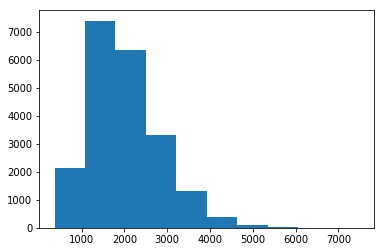

In [314]:
plt.hist(ninety_seven['sqft_living'])

In [288]:
ninety_seven[ninety_seven['sqft_living']>6000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,was_renovated,has_basement
577,1526069135,12/11/2014,930000.0,4,4.00,6050,84942,2.5,0.0,2.0,...,4150,1900.0,2009,98077,47.7466,-122.029,2700,199504,0,1
1537,3425059222,11/24/2014,1300000.0,6,3.50,6563,32670,2.0,0.0,0.0,...,5153,1410.0,2002,98005,47.6078,-122.157,2610,22651,0,1
2123,4379600030,7/29/2014,1330000.0,3,3.75,6400,76665,1.0,0.0,2.0,...,3810,2590,1966,98177,47.7313,-122.370,3430,60548,0,1
2711,7851980260,7/30/2014,1110000.0,5,3.50,7350,12231,2.0,0.0,4.0,...,4750,2600.0,2001,98065,47.5373,-121.865,5380,12587,0,1
3118,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,0.0,0.0,...,6110,0,2005,98059,47.5285,-122.135,4190,10762,0,0
4020,9175600025,10/7/2014,800000.0,7,6.75,7480,41664,2.0,0.0,2.0,...,5080,2400.0,1953,98166,47.4643,-122.368,2810,33190,0,1
11673,1126069045,6/20/2014,1140000.0,6,4.25,6900,244716,2.0,0.0,0.0,...,4820,2080.0,2002,98077,47.7506,-122.012,4170,266587,0,1
15208,1424069069,5/22/2014,1150000.0,6,4.50,6040,219542,2.0,0.0,0.0,...,4100,1940.0,1996,98029,47.5622,-122.003,2010,32362,0,1
18579,3023069166,7/8/2014,1140000.0,5,4.00,7320,217800,2.0,0.0,0.0,...,7320,0,1992,98058,47.4473,-122.086,3270,34500,0,0
18960,1778360150,6/20/2014,1240000.0,7,5.50,6630,13782,2.0,0.0,0.0,...,4930,1700.0,2004,98006,47.5399,-122.118,4470,8639,0,1


In [285]:
too_big[too_big['sqft_living']>12000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,was_renovated,has_basement
7245,6762700020,10/13/2014,7700000.0,6,8.0,12050,27600,2.5,0.0,3.0,...,8570,3480.0,1910,98102,47.6298,-122.323,3940,8800,1,1
12764,1225069038,5/5/2014,2280000.0,7,8.0,13540,307752,3.0,0.0,4.0,...,9410,4130.0,1999,98053,47.6675,-121.986,4850,217800,0,1


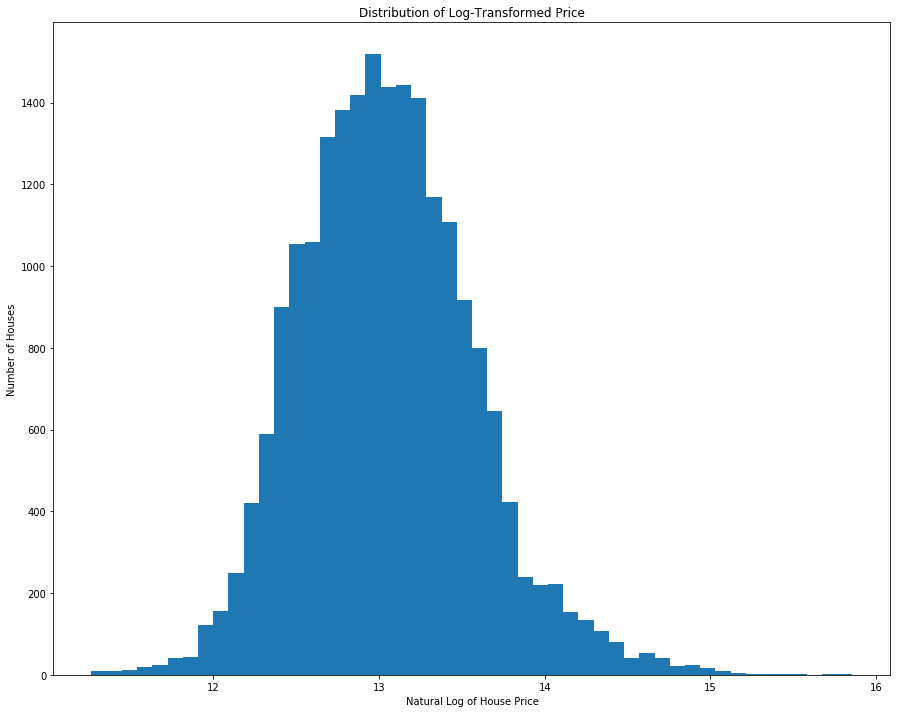

In [15]:
plt.figure(figsize = (15,12))
plt.hist(np.log(kc_houses['price']), bins =50)
plt.xlabel('Natural Log of House Price')
plt.ylabel('Number of Houses')
plt.title('Distribution of Log-Transformed Price')
plt.savefig('log_transformed_price')

Excellent! This distribution looks much more normally distributed. We will use natural log of house price in our linear regression model.


Since sqft_living appeared to be correlated with price in the pairplot, let's take a closer look at the distribution of sqft_living

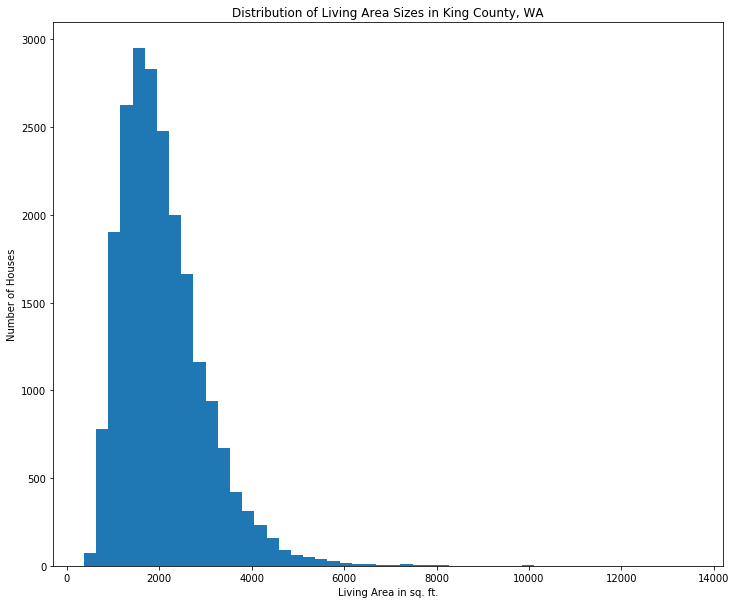

In [263]:
plt.figure(figsize = (12,10))
plt.hist(kc_houses['sqft_living'], bins = 50)
plt.xlabel('Living Area in sq. ft.')
plt.ylabel('Number of Houses')
plt.title('Distribution of Living Area Sizes in King County, WA')
plt.savefig('sqft_living_hist.pdf')
plt.show()

The distribution of house square footage skews sharply to the right. Let's see if log transforming this feature produces a more normal distribution.

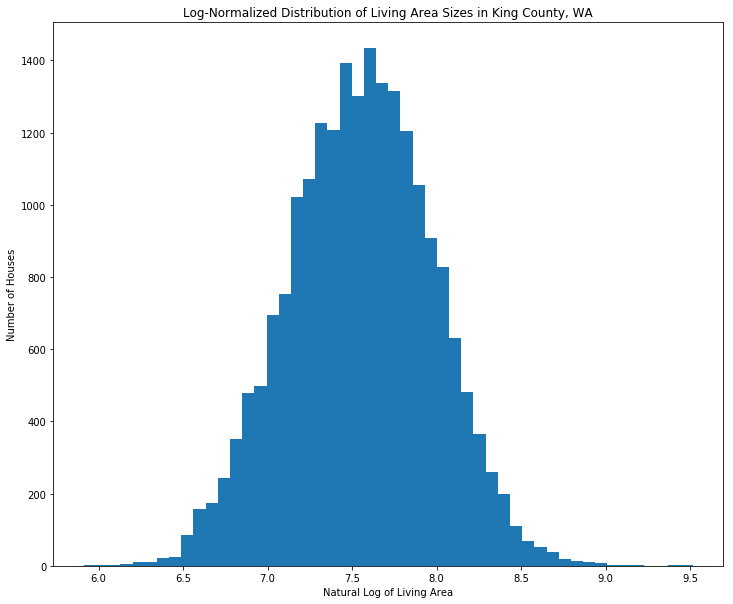

In [17]:
plt.figure(figsize = (12,10))
plt.hist(np.log(kc_houses['sqft_living']), bins = 50)
plt.xlabel('Natural Log of Living Area')
plt.ylabel('Number of Houses')
plt.title('Log-Normalized Distribution of Living Area Sizes in King County, WA')
plt.savefig('log_normalized_living_sqft_dist.pdf')
plt.show()

Much better

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


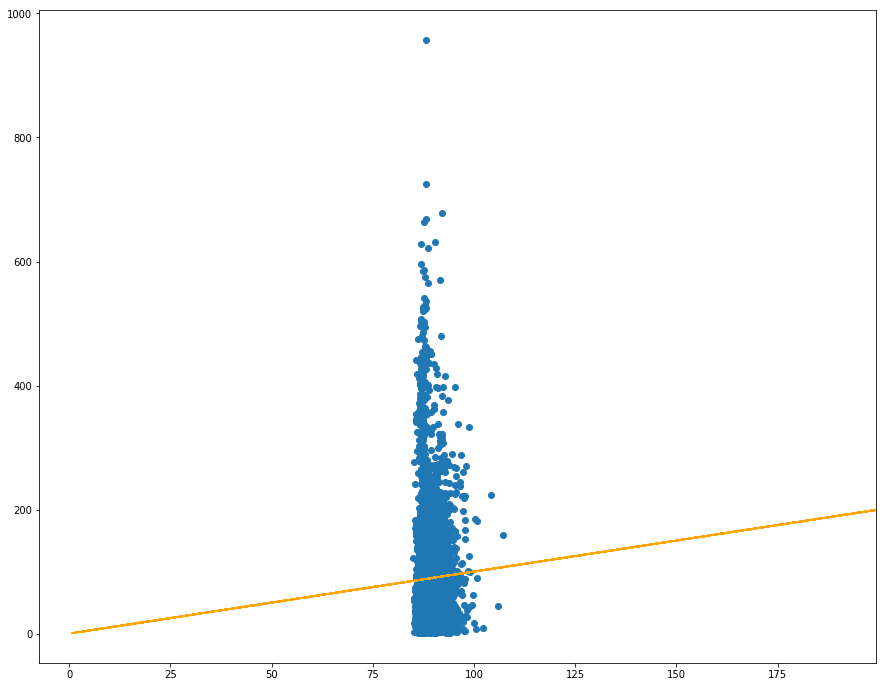

explained variance score:  -0.00021512647013754993
RMSE:  92.22154485664959
[0.00253873]


In [318]:
purse = LinReg()
purse_train, purse_test, target_train, target_test = train_test_split(kc_houses['sqft_living'].as_matrix().reshape(-1,1),kc_houses['price_per_sq_ft_lot'], test_size = 0.2)
Lin_Reg_Model(purse, purse_train, target_train, purse_test, target_test)

In [168]:
from sklearn import preprocessing as pp
scaler = pp.MinMaxScaler()
to_scale = kc_houses[['price','view','lat','sqft_living']]
scaled_features = scaler.fit_transform(to_scale)
scaled_features = pd.DataFrame(scaled_features,columns = ['price','view','lat','sqft_living'])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [160]:
zips = zips.reset_index(drop=True)

In [161]:
to_mod = pd.concat([scaled_df,zips],axis =1)

In [169]:
features_train, features_test, target_train, target_test = train_test_split(scaled_features.drop(columns = ['price']),scaled_features['price'],test_size = 0.2)

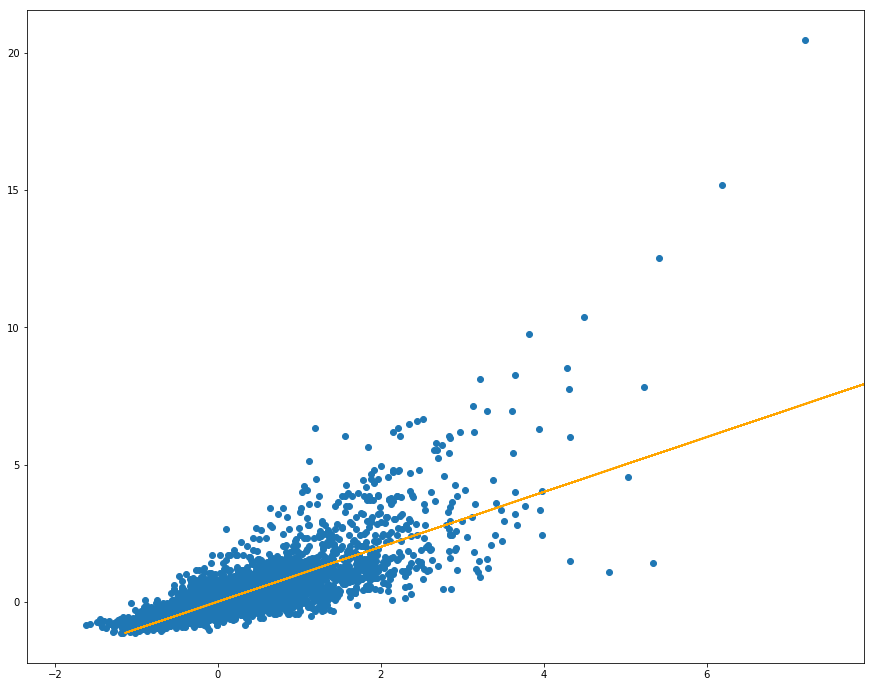

explained variance score:  0.6075196344015691
RMSE:  0.725420344948797
[0.31425033 0.46114624 0.86818473]


In [197]:
Lin_Reg_Model(house_model,features_train, target_train, features_test, target_test)

In [162]:
features_train, features_test, target_train, target_test = train_test_split(scaled_features.drop(columns = ['ln_price']),to_mod['ln_price'],test_size = 0.2)

In [187]:
to_scale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21081 entries, 0 to 21596
Data columns (total 4 columns):
price          21081 non-null float64
view           21081 non-null float64
lat            21081 non-null float64
sqft_living    21081 non-null int64
dtypes: float64(3), int64(1)
memory usage: 1.4 MB


In [188]:
scaled = pd.DataFrame()
ctr = 0
for i in to_scale:
#     curr_col = to_scale.loc[[i]]
    iqr = np.percentile(to_scale[i],75)-np.percentile(to_scale[i],25)
    if iqr == 0:
        scaled[i] = to_scale[i]
    else:
        scaled[i] = to_scale[i].apply(lambda x: (x-to_scale[i].median())/iqr)
    ctr += 1

In [190]:
features_train, features_test, target_train, target_test = train_test_split(scaled.drop(columns = ['price']),scaled['price'],test_size = 0.2)

Because one of our hypotheses was that there is a correlation between location and the price of the housing, we will also want to take a look at several ways to measure this. Latitude and Longitude can list the exact location of the houses, and creating a heatmap of price correlated with Latitude and Longitude can show us the correlation in exact detail.

In [ ]:
import gmaps

gmaps.configure(api_key = "API KEY GOES HERE")

fig = gmaps.figure()

heatmap = gmaps.heatmap_layer(lat_long_df, weights=price_df, dissipating = False)
heatmap.max_intensity = .5
heatmap.point_radius = .005
heatmap.opacity = 1

fig.add_layer(heatmap)
fig

However, as longitude does not have an obvious relationship to price, it may be more useful to group records by zip code, which can give us more distinct neighborhood price ranges. Here we begin to explore housing price as a relation to zip code. There are 70 different zip codes in this data.

In [19]:
kc_houses['zipcode'].nunique()

70

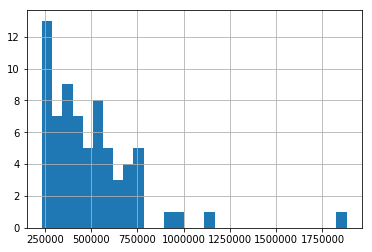

In [20]:
kc_houses.groupby('zipcode')['price'].median().hist(bins = 30)

Median house price appears to vary widely by zip code.  Since zip code is essentially a categorical variable, we will one-hot encode zip code.

In [159]:
zips = pd.get_dummies(kc_houses['zipcode'])

We can later concatenate this dataframe of dummy-coded zipcode to the original dataframe to evaluate the relationship of zipcode to price.  However, let us begin modeling house price by evaluating the relationship of natural log of living area alone to house sale price.

This is our first SIMPLE LINEAR REGRESSION MODEL based on the Natural Log of the Living Area.

In [72]:
to_model_train, to_model_test, target_train,target_test =train_test_split(to_model,target,test_size = 0.2)

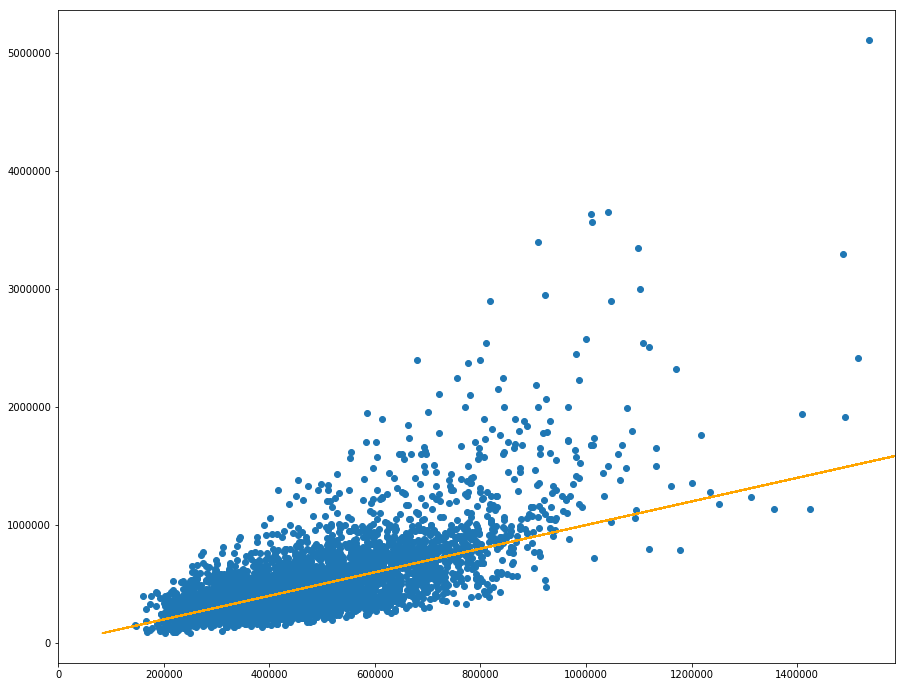

explained variance score:  0.43627476321783487
RMSE:  637479.6884490467


In [73]:
house_model = LinReg()
Lin_Reg_Model_Log(house_model,to_model_train,target_train,to_model_test, target_test)

The above simple linear regression model shows our Predicted House Price, as obtained by our fitting natural log of living area to our Actual House Price. There is a correlation between the two but it is not particularly high, which signifies that we might want to look at other data than just the living area to generate a model that better predicts house price. 

Now we want to take a look at the role that the Zip Code plays in our modeling. Since Zip Code is a categorical variable, we will need to use a "One Hot" encoding method. This is what the function "get_dummies" does. Since there are 70 zip codes it will create 70 new columns. Subsequently, we will concatenate the column containing the natural log of living area to the dataframe containing dummy coded zipcodes.

In [74]:
zip_plus_ln_sq_ft = pd.concat([zips,kc_houses['log_sqft_liv']],axis=1)

In [75]:
minimal_train, minimal_test, target_train, target_test = train_test_split(zip_plus_ln_sq_ft,target, test_size = 0.2)

Above we are once again setting our train test split data. This time we are doing it to incorporate zip code as well as the natural log of the living area for our multiple linear regression model. 

The plot below shows the Multiple Linear Regression line of the Projected Housing Price versus the Actual Price, and it looks to be a <b>fairly good correlation.</b>

We believe that <b>Zip Code</b> and the <b>Natural Log of the Living Area</b> are the factors with the strongest impact on housing price.

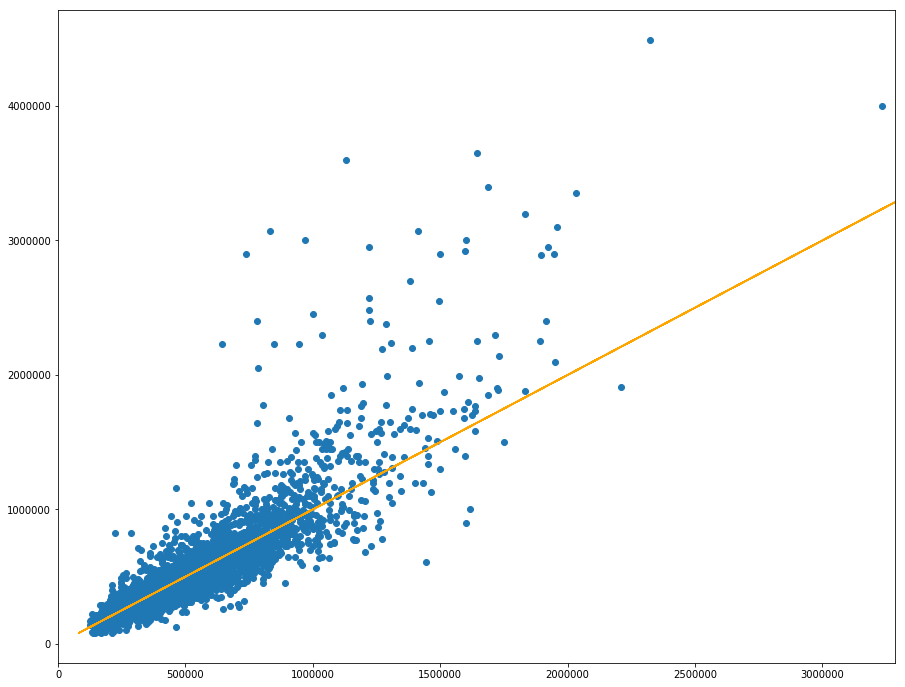

explained variance score:  0.7413011277062056
RMSE:  646461.6937711672


In [76]:
Lin_Reg_Model_Log(house_model,minimal_train,target_train,minimal_test,target_test)

Here we have an Explained Variance Score of .72, suggesting that zip code and the natural log of living area contribute strongly to sale price. 

Now we are going to create a new "Slim Model". This Model, in addition to using Zip Code and the Natural Log of the Living Area, also adds to our model the variables View, Waterfront, Latitude, and Was_Renovated. Recall that Was_Renovated is a simplified "cleaning" of our data because relatively few houses were remodeled at all, so we dummied yr_renovated to simply indicated whether the house was renovated at all.

It will be easier to generate this model if we start the original dataframe, so we will concatenate the zipcode dummies to the original dataframe.

In [77]:
houses_with_zips = pd.concat([kc_houses,zips],axis =1)

In [78]:
houses_with_zips.drop(columns = ['zipcode'],inplace=True)

Because we are doing "One Hot" encoding, the "zipcode" column is now useless. We can drop this column.

In [79]:
slim_model = houses_with_zips.drop(columns = ['id','date','price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','condition','grade','sqft_above','sqft_basement','yr_built','long','sqft_living15','sqft_lot15']) 

We throw out the variables bedrooms, bathrooms, floors, sqft_above, sqft_basement and grade because they are strongly correlated with sqft_living. Condition, yr_built, and long do not appear to have strong relationships with price, so they are thrown out as well.

In [80]:
slim_train, slim_test, target_train, target_test = train_test_split(slim_model,target,test_size = 0.2)

Here we are setting the test train splits for our slimmer model.

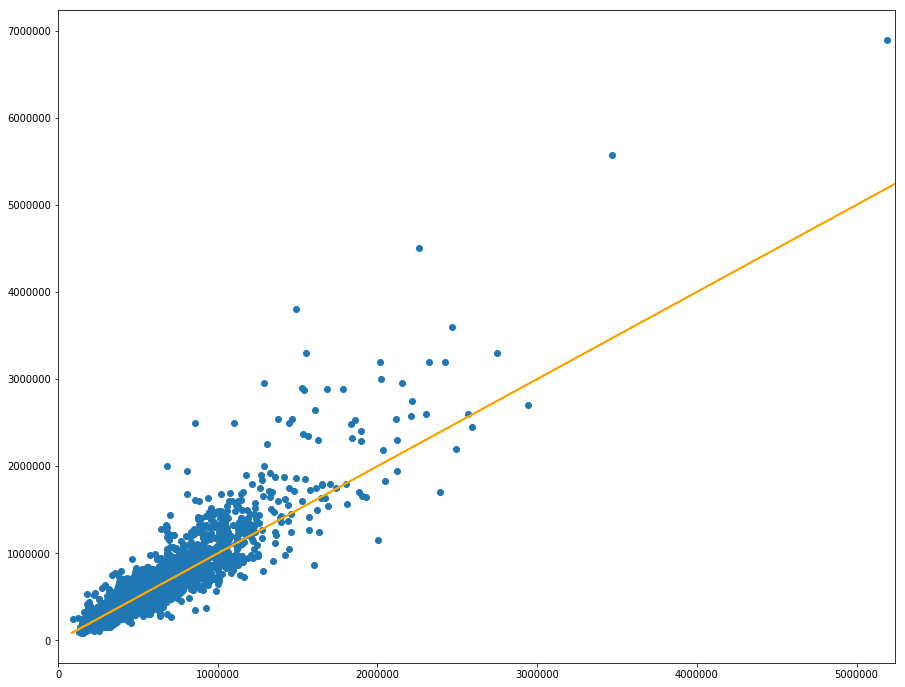

explained variance score:  0.8165122352159659
RMSE:  667021.0786232651


In [81]:
Lin_Reg_Model_Log(house_model,slim_train,target_train,slim_test,target_test)

This looks to show an even stronger relationship between the Predicted House price and the Actual House Price. Above we see an explained variance score of .84. Great score!

Great Model! But consider that we used 6 different columns of data to derive this score and we only used the Natural Log of the Living Space and the Zip Code to receive a model that was almost as effective. So there are strengths and weaknesses of both models.

Either way <h1>Team Haus Masterz</h1> has shown a propensity to develop working models.

It is interesting that for houses that sold for more than about $2000000, our models tend to underpredict house price. 

Although we acheived an explained variance score of more than 0.8, we were not satisfied with these results and explored further means to improve our models performance.  First, wewe investigated whether price per square foot might be a more meaningful target than absolute price. 

In [118]:
kc_houses['price_per_sq_ft']= kc_houses['price']/kc_houses['sqft_living']

(array([3148., 6172., 5587., 3104., 1619.,  707.,  389.,  197.,  109.,
          49.]), array([ 87.58823529, 158.82941176, 230.07058824, 301.31176471,
        372.55294118, 443.79411765, 515.03529412, 586.27647059,
        657.51764706, 728.75882353, 800.        ]), <a list of 10 Patch objects>)

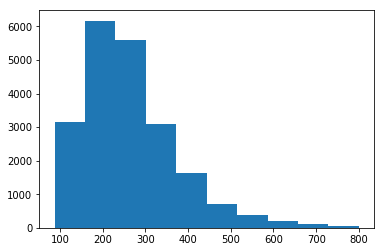

In [105]:
plt.hist(kc_houses['price_per_sq_ft'])

(array([ 283., 1096., 2771., 3660., 4373., 4215., 2699., 1233.,  560.,
         191.]),
 array([4.47264669, 4.69384319, 4.9150397 , 5.1362362 , 5.3574327 ,
        5.57862921, 5.79982571, 6.02102222, 6.24221872, 6.46341522,
        6.68461173]),
 <a list of 10 Patch objects>)

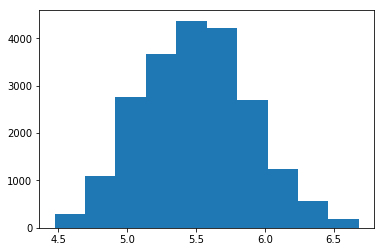

In [106]:
plt.hist(np.log(kc_houses['price_per_sq_ft']))

In [107]:
kc_houses['price_per_sq_ft'].describe()

count    21081.000000
mean       264.126429
std        110.065719
min         87.588235
25%        182.242991
50%        244.680851
75%        318.066158
max        800.000000
Name: price_per_sq_ft, dtype: float64

In [119]:
per_sq_ft = pd.concat([kc_houses,zips],axis =1)

In [109]:
per_sq_ft.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
count,2.108100e+04,2.108100e+04,21081.000000,21081.000000,21081.000000,2.108100e+04,21081.000000,21081.000000,21081.000000,21081.000000,...,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000,21081.000000
mean,4.582897e+09,5.402422e+05,3.370998,2.115934,2080.381813,1.507802e+04,1.493644,0.006688,0.233338,3.409753,...,0.013187,0.002609,0.020635,0.011764,0.012381,0.011906,0.012239,0.006214,0.012808,0.014847
std,2.876452e+09,3.667404e+05,0.902228,0.768156,917.872690,4.117431e+04,0.539372,0.081511,0.765083,0.650520,...,0.114079,0.051013,0.142161,0.107825,0.110581,0.108468,0.109951,0.078586,0.112447,0.120945
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.123700e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.904980e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.312200e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.069800e+04,2.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
# per_sq_ft['log_price_per'] = np.log(per_sq_ft['price_per_sq_ft'])

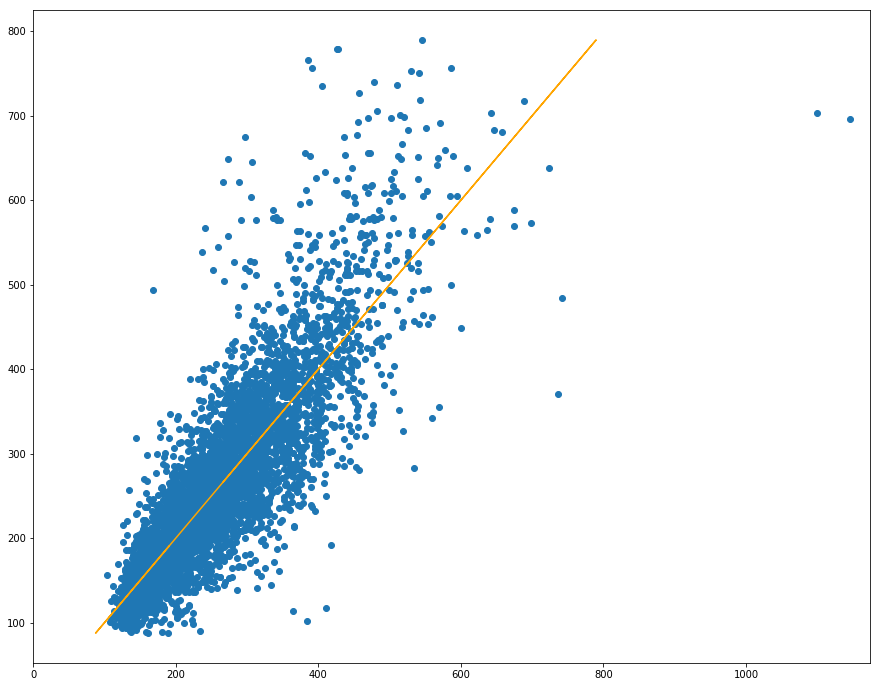

explained variance score:  0.7183215413907844
RMSE:  279.25153725029065


In [122]:
purse_train, purse_test, per_train, per_test = train_test_split(per_sq_ft.drop(columns = ['id','date','price','price_per_sq_ft','sqft_living','sqft_lot','bedrooms','bathrooms','condition','grade','long','sqft_living15','sqft_lot15']),per_sq_ft['price_per_sq_ft'])
Lin_Reg_Model_Log(house_model,purse_train,per_train,purse_test,per_test)


Fitting a model to price/sq. ft. rather than absolute price does not appear to improve explained variance.  Furthermore, fitting to price/sq. ft. appears to continues to underpredict sale prices for very expensive houses, with the exception of two houses whose price the model wildly overpredicted. This tendency to underpredict price toward the right extreme of the distribution may suggest the price may need to be standardized by some means other than log transformation.

Next we tried scaling the features used so that all had a minimum of zero and maximum of 1 without standardizing the features.

In [125]:
scaled_df = pd.DataFrame(scaled_features, columns = ['view','lat','log_sqft_liv','ln_price'])

In [126]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21081 entries, 0 to 21080
Data columns (total 4 columns):
view            21081 non-null float64
lat             21081 non-null float64
log_sqft_liv    21081 non-null float64
ln_price        21081 non-null float64
dtypes: float64(4)
memory usage: 658.9 KB


Scaling does slightly improve explained variance, but not by much.  This is likely because log normalizing price and sqft_living already narrowed the range of these values and brought the mean closer to 0.

Finally we investigated whether including year built affects model perfromance.

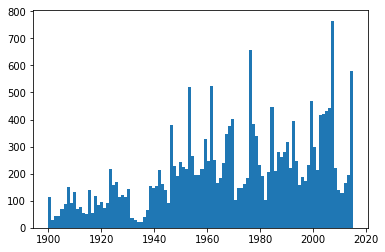

In [42]:
plt.hist(kc_houses['yr_built'], bins =100)
plt.show()

This is a histogram of the number of houses by each year built. It's pretty cool in showing the housing growth in the county, as well as the time periods in which construction slows (the great depression seems to have made a pretty significant impact here.)

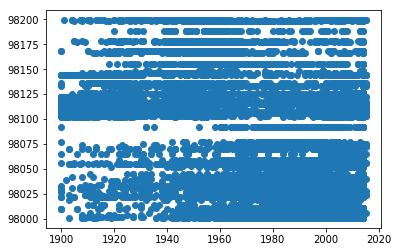

In [44]:
plt.scatter(kc_houses['yr_built'],kc_houses['zipcode'])
plt.show()

We thought that there may be a correlation between the zipcode and the year built. This data produces some interesting results, notably that there are some zip codes that were not producing houses until certain historical time periods. However, there isn't really much here in the data that could show correlation between zipcode and year built, and there also isn't much here that would suggest that year built relates to housing price.

But lets go ahead and ask the question below, just to see if there are any changes between our previous model and the "Slim Model" we had above that showed Team Haus Masterz with such a good variance score. 

The question being does year built help explain our Housing Prices?

In [45]:
kc_houses['yr_built'].nunique()

116

In [73]:
kc_houses.groupby(['zipcode','yr_built'])['price'].median().head()
#dont cut this is the median house by zipcode AND year built.

zipcode  yr_built
98001    1903        230000.0
         1908        213750.0
         1909        185900.0
         1912        170000.0
         1913        168000.0
Name: price, dtype: float64

The above chart is just a preview of the data we have showing the median price of each home as organized first my the zipcode and secondarily by the year that it was built. What can we do with this data?

In [47]:
year_built = pd.get_dummies(houses_with_zips['yr_built'])
houses_with_zips_and_years = pd.concat([houses_with_zips,year_built],axis=1)
houses_with_zips_and_years.drop(columns = ['yr_built'],inplace=True)

The above code is our way to encode categorical variables, in this case year built. There are 116 different years that houses were built in this data. 

As we noted earlier, our "One Hot" version of encoding works by creating 116 different columns, and entering boolean values for whether each individual house was built in a given year or not.

In [75]:
everything = houses_with_zips_and_years.drop(columns = ['id','date','price','sqft_lot','sqft_lot15','sqft_living15','bathrooms'])
target = houses_with_zips['price']
everything_train, everything_test, target_train, target_test = train_test_split(everything,target,test_size=.2)
#the point of this code is to see if year built has an impact on the model and it doesnt.

The point of the code above is to build a similar model to the one we had earlier, only seeing if the year built has an impact on the model. It appears below that there isn't much of a difference.

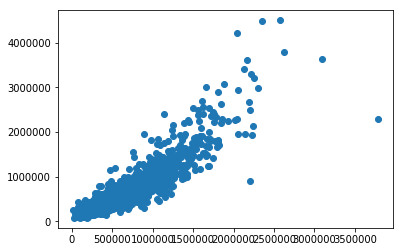

In [78]:
mod = house_model.fit(everything_train,target_train)
y_pred = mod.predict(everything_test)
plt.scatter(y_pred,target_test)
plt.show()

In [79]:
explained_variance_score(target_test,y_pred)

0.8184938473315362

So there you have it - Team Haus Masterz has successfully answered the tough questions about King County Housing Data. Our principal conclusions are thus:
- Both the locations as measured by Zip Code and the Natural Log of the Living Area are good measurements for predicting housing prices.
- This is a little different from our initial hypothesis that the size of the Haus has a positive correlation. 
- Year Built actually has very little to no correlation with Housing Prices.